### Getting Started
Import requirements, set style for plots, and connect to DB

In [ ]:
# Install requirements to the env
#!pip install -r requirements.txt

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline

# Set the style for our plots
plt.style.use('seaborn-v0_8-whitegrid')

# Connect to the SQLite database
conn = sqlite3.connect('papcorns.sqlite')


### Helper Functions

run_query: Executes SQL query and return results as DataFrame
check_unique_years: Checks unique years and date range in a dataframe's datetime column

In [151]:
# Execute SQL queries
def run_query(query):
    """Execute SQL query and return results as DataFrame"""
    return pd.read_sql_query(query, conn)

# Check Unique Years and Date Range
def check_unique_years(dataframe, date_column='created_at'):
    '''Check unique years and date range in a dataframe's datetime column.'''
    # Make sure the date column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(dataframe[date_column]):
        print(f"Converting {date_column} to datetime...")
        dataframe[date_column] = pd.to_datetime(dataframe[date_column])
    
    # Check unique years in the data
    years = dataframe[date_column].dt.year.unique()
    print(f"\nUnique years in data: {sorted(years)}")
    
    # Get min and max dates
    min_date = dataframe[date_column].min()
    max_date = dataframe[date_column].max()
    
    print(f"Date range: {min_date} to {max_date}")
    
    return years, min_date, max_date

### Database Exploration
We started by exploring the database structure to understand the data better, checking for missing values, and examining value distributions.

In [152]:
# Load Tables as DataFrames
users_df = run_query("SELECT * FROM users")
events_df = run_query("SELECT * FROM user_events")

# Display basic information about the tables
print("--------------------------------USERS---------------------------------------")
print(users_df.info())
print(users_df.head())
print("\nMissing values in users_df:")
print(users_df.isnull().sum())
print("\nUnique attribution sources:", users_df['attribution_source'].unique())
print("Unique countries:", users_df['country'].unique())

print("---------------------------USER EVENTS---------------------------------------")
print(events_df.info())
print(events_df.head())
print("\nMissing values in events_df:")
print(events_df.isnull().sum())
print("Unique event names:", events_df['event_name'].unique())

# Check temporal distribution
check_unique_years(users_df)
check_unique_years(events_df)

--------------------------------USERS---------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1002 non-null   int64 
 1   created_at          1002 non-null   object
 2   attribution_source  1002 non-null   object
 3   country             1002 non-null   object
 4   name                1002 non-null   object
dtypes: int64(1), object(4)
memory usage: 39.3+ KB
None
   id           created_at attribution_source country          name
0   1  2024-05-07T00:00:00          instagram      US     Eve Brown
1   2  2024-10-12T00:00:00          instagram      NL   Frank Moore
2   3  2024-10-15T00:00:00             tiktok      TR  Ivy Anderson
3   4  2024-08-28T00:00:00             tiktok      TR   Alice Brown
4   5  2024-04-03T00:00:00            organic      NL     Bob Moore

Missing values i

(array([2024, 2025], dtype=int32),
 Timestamp('2024-01-01 00:00:00'),
 Timestamp('2025-07-12 00:00:00'))

#### Users Data Analysis:

User Volume: The database contains 1,002 users.

User Demographics: Users come from 3 countries (US, NL, TR) and 3 attribution sources (instagram, tiktok, organic).

Temporal Distribution: User data spans from January 2024 to February 2025, with a date range of 2024-01-01 to 2025-02-16.

Data Structure: Most columns are stored as object type, with 'id' as int64. The 'created_at' column requires datetime conversion.

Completeness: No NULL values detected in the users table.

#### User Events Analysis:

Event Volume: 3,486 events are recorded in the database.

Event Types: Six distinct event types capturing the full user journey (app_install, trial_started, trial_cancelled, subscription_started, subscription_renewed, subscription_cancelled).

Missing Values: 2,255 missing values in the 'amount_usd' column (64.7% of events).

Temporal Range: Event data spans from January 2024 to July 2025, with a date range of 2024-01-01 to 2025-07-12, extending beyond the user creation date range.

Data Types: Two integer columns (id, user_id), two object columns (created_at, event_name), and one float column (amount_usd).

### Data Validation and Cleaning

In [153]:
# Convert timestamp strings to datetime objects
users_df['created_at'] = pd.to_datetime(users_df['created_at'])
events_df['created_at'] = pd.to_datetime(events_df['created_at'])

# Check for empty strings in text fields
for column in ['attribution_source', 'country', 'name']:
    empty_count = (users_df[column] == '').sum()
    print(f"Empty strings in {column}: {empty_count}")

# Investigate which event types have missing amount_usd values
event_missing_amount = events_df[events_df['amount_usd'].isnull()]['event_name'].value_counts()
print("\nEvent types with missing amount_usd values:")
print(event_missing_amount)

# Determine if missing values are expected or problematic
non_transactional_events = ['app_install', 'trial_started', 'trial_cancelled', 'subscription_cancelled']
expected_missing = events_df[events_df['event_name'].isin(non_transactional_events)]['amount_usd'].isnull().sum()
unexpected_missing = events_df[~events_df['event_name'].isin(non_transactional_events)]['amount_usd'].isnull().sum()

print(f"\nExpected missing amount_usd values (non-transactional events): {expected_missing}")
print(f"Unexpected missing amount_usd values (transactional events): {unexpected_missing}")

Empty strings in attribution_source: 0
Empty strings in country: 0
Empty strings in name: 0

Event types with missing amount_usd values:
event_name
app_install               1002
trial_started              682
subscription_cancelled     370
trial_cancelled            201
Name: count, dtype: int64

Expected missing amount_usd values (non-transactional events): 2255
Unexpected missing amount_usd values (transactional events): 0


#### Data Quality Findings:

Future-Dated Records: The data spans from January 1, 2024 to July 12, 2025 for events, and from January 1, 2024 to February 16, 2025 for users. Since the data extends into 2025, this suggests this is likely test data or includes projections.

Missing Values in amount_usd: All 2,255 missing values in the 'amount_usd' column are accounted for:

App installs: 1,002 missing values (100% of app installs)
Trial started: 682 missing values
Subscription cancelled: 370 missing values
Trial cancelled: 201 missing values
No unexpected missing values in revenue-generating events (subscription_started, subscription_renewed)


Empty Strings: Checked for empty strings in all categorical fields:

Attribution source: 0 empty strings
Country: 0 empty strings
Name: 0 empty strings


Data Completeness: These results confirm proper data completeness with missing values occurring only where expected in the amount_usd field for non-transactional events.

This validation confirms the data is clean and suitable for the analysis tasks. The missing amount values are entirely expected and don't represent a data quality issue. All events that should have monetary values (subscription events) have complete data, which means our revenue calculations will be accurate.

### Task 1: Calculate the total revenue generated from subscriptions for each country

Total Revenue by Country
  country  total_revenue
0      US        4035.96
1      NL        3335.29
2      TR        2275.44


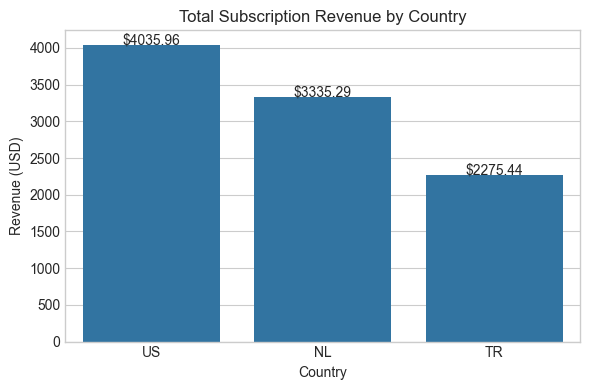

In [154]:
task1_query = """
SELECT 
    u.country,
    SUM(e.amount_usd) as total_revenue
FROM 
    users u
JOIN 
    user_events e ON u.id = e.user_id
WHERE 
    e.event_name IN ('subscription_started', 'subscription_renewed')
GROUP BY 
    u.country
ORDER BY 
    total_revenue DESC
"""

revenue_by_country = run_query(task1_query)
print("Total Revenue by Country")
print(revenue_by_country)

# Visualize the results
plt.figure(figsize=(6, 4))
sns.barplot(x='country', y='total_revenue', data=revenue_by_country)
plt.title('Total Subscription Revenue by Country')
plt.xlabel('Country')
plt.ylabel('Revenue (USD)')

plt.xticks(rotation=0)
for i, row in enumerate(revenue_by_country.itertuples()):
    plt.text(i, row.total_revenue + 5, f"${row.total_revenue:.2f}", ha='center')
plt.tight_layout()
plt.savefig('Task1_revenue_by_country.png')
plt.show()

Analysis of Task 1 Results:

The United States (US) leads with the highest total revenue at $4,035.96

Netherlands (NL) is in second place with $3,335.29

Turkey (TR) has the lowest total revenue at $2,275.44

This distribution shows that the US generates about 42% more revenue than Turkey and about 21% more than the Netherlands. 

The US market is clearly the most valuable in terms of total revenue contribution

### Task 2: Calculate the total number of trials given to users who came from Instagram


In [155]:
task2_query = """
SELECT 
    COUNT(*) as total_instagram_trials
FROM 
    users u
JOIN 
    user_events e ON u.id = e.user_id
WHERE 
    u.attribution_source = 'instagram' AND 
    e.event_name = 'trial_started'
"""

insta_trials = run_query(task2_query)
print(insta_trials)

   total_instagram_trials
0                     210


Total of 210 trials were given to users who came from Instagram.

### Task 3: Create a new column 'acquisition_channel' by categorizing users based on their 'attribution_source'


   id            name attribution_source acquisition_channel
0   1       Eve Brown          instagram                Paid
1   2     Frank Moore          instagram                Paid
2   3    Ivy Anderson             tiktok                Paid
3   4     Alice Brown             tiktok                Paid
4   5       Bob Moore            organic             Organic
5   6    Frank Miller             tiktok                Paid
6   7     Henry Moore          instagram                Paid
7   8     Alice Moore             tiktok                Paid
8   9  Frank Anderson            organic             Organic
9  10  David Anderson            organic             Organic
------------------------------------
acquisition_channel
Paid       658
Organic    344
Name: count, dtype: int64


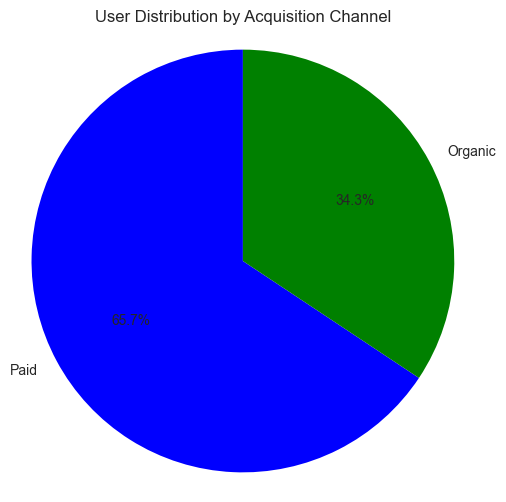

In [156]:
# Add 'acquisition_channel' column to users_df
users_df['acquisition_channel'] = users_df['attribution_source'].apply(
    lambda x: 'Paid' if x in ['instagram', 'tiktok'] else 'Organic')
print(users_df[['id', 'name', 'attribution_source', 'acquisition_channel']].head(10))

# Count users in each acquisition channel
channel_counts = users_df['acquisition_channel'].value_counts()
print("------------------------------------")
print(channel_counts)

# Create a pie chart to visualize the distribution
plt.figure(figsize=(6, 6))
plt.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', startangle=90, 
       colors=['blue', 'green'])
plt.title('User Distribution by Acquisition Channel')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.savefig('Task3_acquisition_channel_distribution.png')
plt.show()

Users are categorized into two acquisition channels:

Paid: 658 users (65.7%)

Organic: 344 users (34.3%)

This distribution shows that nearly two-thirds of users come through paid channels (Instagram and TikTok), while about one-third come through organic sources.

### Task 4: Analyze the trial-to-subscription conversion rate

   total_trials  converted_to_subscription  conversion_rate
0           682                        481         0.705279
-----------------------------------------------------------------------------
  attribution_source  total_trials  converted_to_subscription  conversion_rate
0            organic           236                        169         0.716102
1          instagram           210                        149         0.709524
2             tiktok           236                        163         0.690678


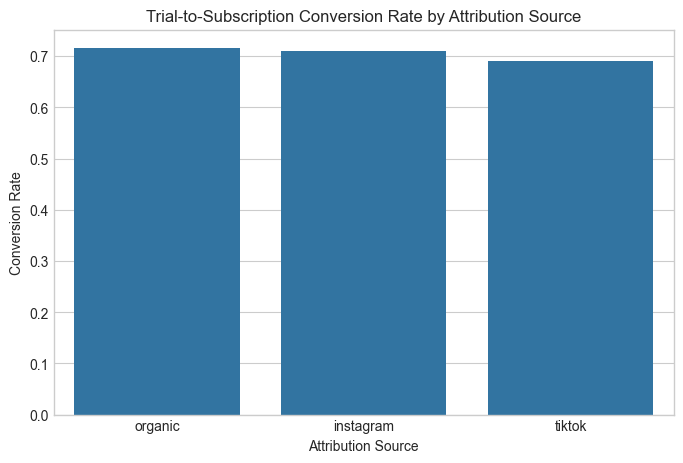

In [157]:
# 4.1 Overall conversion rate
# We need to find users who started a trial and then check which ones started a subscription
overall_conversion_query = """
WITH trials AS (
    SELECT DISTINCT user_id
    FROM user_events
    WHERE event_name = 'trial_started'
),
subscriptions AS (
    SELECT DISTINCT user_id
    FROM user_events
    WHERE event_name = 'subscription_started'
)
SELECT 
    COUNT(DISTINCT t.user_id) as total_trials,
    COUNT(DISTINCT s.user_id) as converted_to_subscription,
    CAST(COUNT(DISTINCT s.user_id) AS FLOAT) / COUNT(DISTINCT t.user_id) as conversion_rate
FROM trials t
LEFT JOIN subscriptions s ON t.user_id = s.user_id
"""

overall_conversion = run_query(overall_conversion_query)
print(overall_conversion)
print('-----------------------------------------------------------------------------')

# 4.2 Conversion rate by attribution source
conversion_by_source_query = """
WITH trials AS (
    SELECT e.user_id, u.attribution_source
    FROM user_events e
    JOIN users u ON e.user_id = u.id
    WHERE e.event_name = 'trial_started'
),
subscriptions AS (
    SELECT user_id
    FROM user_events
    WHERE event_name = 'subscription_started'
)
SELECT 
    t.attribution_source,
    COUNT(DISTINCT t.user_id) as total_trials,
    COUNT(DISTINCT s.user_id) as converted_to_subscription,
    CAST(COUNT(DISTINCT s.user_id) AS FLOAT) / COUNT(DISTINCT t.user_id) as conversion_rate
FROM trials t
LEFT JOIN subscriptions s ON t.user_id = s.user_id
GROUP BY t.attribution_source
ORDER BY conversion_rate DESC
"""

conversion_by_source = run_query(conversion_by_source_query)
print(conversion_by_source)

# Visualize conversion rates by attribution source
plt.figure(figsize=(8, 5))
sns.barplot(x='attribution_source', y='conversion_rate', data=conversion_by_source)
plt.title('Trial-to-Subscription Conversion Rate by Attribution Source')
plt.xlabel('Attribution Source')
plt.ylabel('Conversion Rate')
plt.savefig('Task4_conversion_rate_by_source.png')
plt.show()

Overall Conversion Rate: 481 out of 682 trials converted to subscriptions, resulting in a 70.53% overall conversion rate.
Conversion Rate by Attribution Source:

Organic: 71.61% (169 out of 236 trials converted)

Instagram: 70.95% (149 out of 210 trials converted)

TikTok: 69.07% (163 out of 236 trials converted)



The differences in conversion rates between attribution sources are relatively small, with organic sources performing slightly better than paid channels. This suggests that users who find the service organically have a marginally higher tendency to convert to paid subscriptions.

### Task 5: Calculate the median subscription duration (in months) for each country
For this task, we need to find the duration between subscription_started and subscription_cancelled events


  country  months_subscribed
0      NL           2.726675
1      TR           2.825230
2      US           2.529566


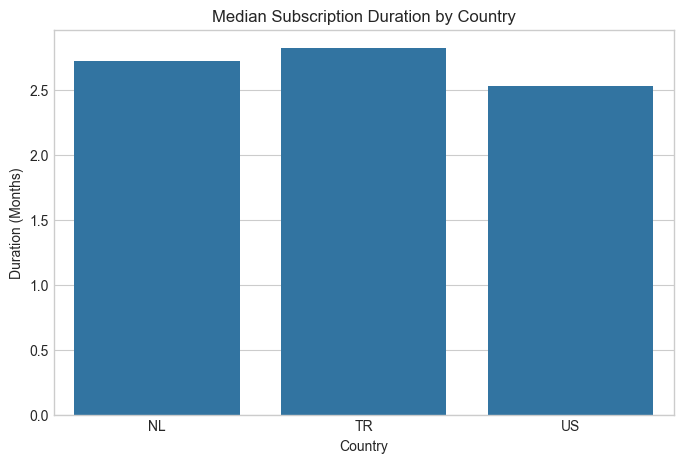

In [158]:

# SQL approach to calculate subscription durations
subscription_duration_query = """
WITH sub_starts AS (
    SELECT user_id, created_at as start_date
    FROM user_events
    WHERE event_name = 'subscription_started'
),
sub_cancels AS (
    SELECT user_id, created_at as end_date
    FROM user_events
    WHERE event_name = 'subscription_cancelled'
)
SELECT 
    u.id as user_id,
    u.country,
    s.start_date,
    c.end_date,
    JULIANDAY(COALESCE(c.end_date, CURRENT_TIMESTAMP)) - JULIANDAY(s.start_date) as days_subscribed,
    (JULIANDAY(COALESCE(c.end_date, CURRENT_TIMESTAMP)) - JULIANDAY(s.start_date)) / 30.44 as months_subscribed
FROM sub_starts s
LEFT JOIN sub_cancels c ON s.user_id = c.user_id
JOIN users u ON s.user_id = u.id
"""

subscription_durations = run_query(subscription_duration_query)

# Calculate median durations by country
median_duration_by_country = subscription_durations.groupby('country')['months_subscribed'].median().reset_index()
print(median_duration_by_country)

# Visualize median durations
plt.figure(figsize=(8, 5))
sns.barplot(x='country', y='months_subscribed', data=median_duration_by_country)
plt.title('Median Subscription Duration by Country')
plt.xlabel('Country')
plt.ylabel('Duration (Months)')
plt.savefig('Task5_median_duration_by_country.png')
plt.show()

The median subscription duration varies slightly across the three countries:

Turkey (TR) has the longest median subscription duration at 2.83 months

Netherlands (NL) is in the middle with 2.73 months

United States (US) has the shortest median duration at 2.53 months

While the US generates the highest total revenue (from Task 1), users from Turkey tend to maintain their subscriptions for a longer period. The difference between the highest and lowest median duration is only about 0.3 months (approximately 9 days), suggesting relatively consistent retention across countries.

### Task 6: Calculate the Average Lifetime Value (LTV) by country




-Average Lifetime Value (LTV) by Country
  country  average_ltv
0      US    25.068075
1      NL    22.384497
2      TR    13.306667


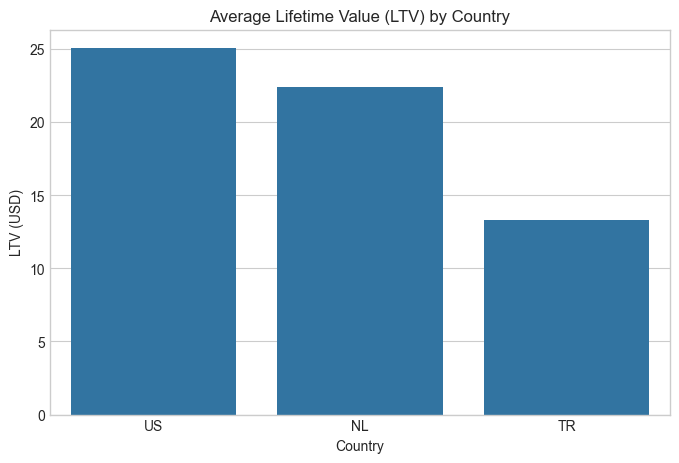

In [ ]:
ltv_query = """
SELECT 
    u.country,
    AVG(revenue) as average_ltv
FROM (
    SELECT 
        user_id,
        SUM(amount_usd) as revenue
    FROM 
        user_events
    WHERE 
        event_name IN ('subscription_started', 'subscription_renewed')
    GROUP BY 
        user_id
) revenue
JOIN 
    users u ON revenue.user_id = u.id
GROUP BY 
    u.country
ORDER BY 
    average_ltv DESC
"""

ltv_by_country = run_query(ltv_query)
print("\n-Average Lifetime Value (LTV) by Country")
print(ltv_by_country)

# Visualize LTV by country
plt.figure(figsize=(8,5))
sns.barplot(x='country', y='average_ltv', data=ltv_by_country)
plt.title('Average Lifetime Value (LTV) by Country')
plt.xlabel('Country')
plt.ylabel('LTV (USD)')
plt.savefig('Task6_ltv_by_country.png')
plt.show()

The Average Lifetime Value (LTV) varies significantly across countries:

United States (US) has the highest average LTV at $25.07

Netherlands (NL) is in the middle with an average LTV of $22.38

Turkey (TR) has the lowest average LTV at $13.31

This shows that US users are nearly twice as valuable ($25.07/$13.31 = 1.88 times) as Turkish users in terms of lifetime revenue.
Remember from Task5, where Turkish users had the longest subscription duration; this new finding suggests that while Turkish users might stay subscribed longer, they likely generate less revenue per month, possibly due to different pricing tiers or promotion strategies in that market.